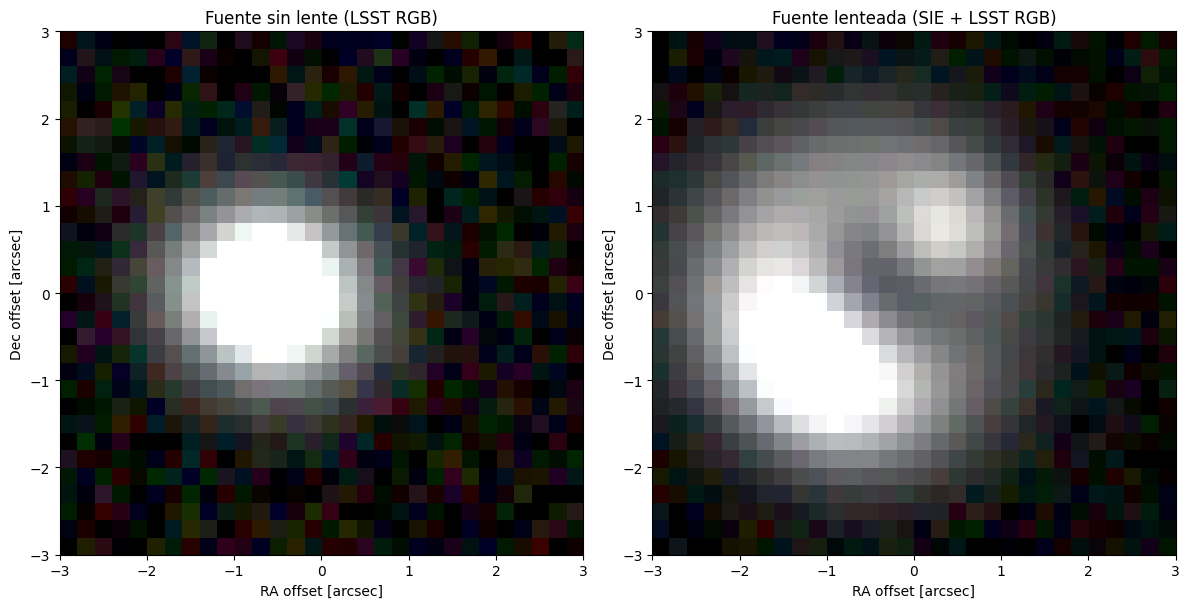

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from lenstronomy.SimulationAPI.ObservationConfig.LSST import LSST
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.Plots import plot_util

# ------------------------
# CONFIGURACIÓN INICIAL
# ------------------------
size = 6.0  # arcsec
mag_g = 21
g_r, g_i = 1.0, 2.0  # colores

# Configuración de bandas LSST
LSST_g = LSST(band='g', psf_type='GAUSSIAN', coadd_years=10)
LSST_r = LSST(band='r', psf_type='GAUSSIAN', coadd_years=10)
LSST_i = LSST(band='i', psf_type='GAUSSIAN', coadd_years=10)
lsst_bands = [LSST_g, LSST_r, LSST_i]

# Modelo de lente (SIE) + fuente (Sersic)
kwargs_model_lens = {
    'lens_model_list': ['SIE'],
    'source_light_model_list': ['SERSIC_ELLIPSE'],
    'lens_light_model_list': [],
    'point_source_model_list': []
}

kwargs_model_nolens = {
    'lens_model_list': [],
    'source_light_model_list': ['SERSIC_ELLIPSE'],
    'lens_light_model_list': [],
    'point_source_model_list': []
}

kwargs_lens = [{'theta_E': 1.0, 'e1': 0.2, 'e2': 0.0, 'center_x': 0, 'center_y': 0.5}]

# Fuente Sersic multibanda
kwargs_source_mag_g = [{'magnitude': mag_g, 'R_sersic': 0.4, 'n_sersic': 1,
                        'e1': 0.05, 'e2': -0.05, 'center_x': -0.6, 'center_y': 0.0}]
kwargs_source_mag_r = [{'magnitude': mag_g - g_r, **kwargs_source_mag_g[0]}]
kwargs_source_mag_i = [{'magnitude': mag_g - g_i, **kwargs_source_mag_g[0]}]

kwargs_source_all = [kwargs_source_mag_g, kwargs_source_mag_r, kwargs_source_mag_i]

kwargs_numerics = {'point_source_supersampling_factor': 1}

# ------------------------
# FUNCIÓN DE SIMULACIÓN RGB
# ------------------------
def simulate_rgb(ConfigList, kwargs_model, lens_params, source_mags, size=6, kwargs_numerics=None):
    band_g, band_r, band_i = ConfigList
    kw_g, kw_r, kw_i = band_g.kwargs_single_band(), band_r.kwargs_single_band(), band_i.kwargs_single_band()
    pixel_scale = kw_g['pixel_scale']
    numpix = int(round(size / pixel_scale))

    # Simuladores por banda
    sim_g = SimAPI(numpix, kw_g, kwargs_model)
    sim_r = SimAPI(numpix, kw_r, kwargs_model)
    sim_i = SimAPI(numpix, kw_i, kwargs_model)

    # Magnitudes a amplitudes
    _, source_g, _ = sim_g.magnitude2amplitude([], source_mags[0], [])
    _, source_r, _ = sim_r.magnitude2amplitude([], source_mags[1], [])
    _, source_i, _ = sim_i.magnitude2amplitude([], source_mags[2], [])

    # Modelos de imagen
    imSim_g = sim_g.image_model_class(kwargs_numerics)
    imSim_r = sim_r.image_model_class(kwargs_numerics)
    imSim_i = sim_i.image_model_class(kwargs_numerics)

    # Imágenes individuales con ruido
    img_g_raw = imSim_g.image(lens_params, source_g, None, None)
    img_r_raw = imSim_r.image(lens_params, source_r, None, None)
    img_i_raw = imSim_i.image(lens_params, source_i, None, None)

    img_g = img_g_raw + sim_g.noise_for_model(model=img_g_raw)
    img_r = img_r_raw + sim_r.noise_for_model(model=img_r_raw)
    img_i = img_i_raw + sim_i.noise_for_model(model=img_i_raw)


    # Fusionar RGB
    def _scale_max(image): 
        flat = image.flatten()
        flat.sort()
        return flat[int(len(flat)*0.95)]

    img = np.zeros((numpix, numpix, 3), dtype=float)
    img[:,:,0] = plot_util.sqrt(img_i, scale_min=0, scale_max=_scale_max(img_i))  # R
    img[:,:,1] = plot_util.sqrt(img_r, scale_min=0, scale_max=_scale_max(img_r))  # G
    img[:,:,2] = plot_util.sqrt(img_g, scale_min=0, scale_max=_scale_max(img_g))  # B
    return img

# ------------------------
# EJECUTAR SIMULACIONES
# ------------------------

# Fuente + lente
img_lensed = simulate_rgb(lsst_bands, kwargs_model_lens, kwargs_lens, kwargs_source_all, size=size, kwargs_numerics=kwargs_numerics)

# Solo fuente (sin lente)
img_source = simulate_rgb(lsst_bands, kwargs_model_nolens, [], kwargs_source_all, size=size, kwargs_numerics=kwargs_numerics)

# ------------------------
# VISUALIZACIÓN
# ------------------------
# Obtener escala de píxel (arcsec/pix) y dimensiones
pixel_scale = lsst_bands[0].kwargs_single_band()['pixel_scale']
extent = [-size/2, size/2, -size/2, size/2]  # en arcsec

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Fuente sin lente
axs[0].imshow(img_source, origin='lower', extent=extent)
axs[0].set_title("Fuente sin lente (LSST RGB)")
axs[0].set_xlabel("RA offset [arcsec]")
axs[0].set_ylabel("Dec offset [arcsec]")

# Fuente lenteada
axs[1].imshow(img_lensed, origin='lower', extent=extent)
axs[1].set_title("Fuente lenteada (SIE + LSST RGB)")
axs[1].set_xlabel("RA offset [arcsec]")
axs[1].set_ylabel("Dec offset [arcsec]")

plt.tight_layout()
plt.show()


In [4]:
img_lensed.shape

(30, 30, 3)

In [5]:
img_source.shape

(30, 30, 3)